In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import halfnorm

from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform

from MINOV.density import *

import matplotlib.pyplot as plt
from style import mpl_style

Custom matplotlib styles have been applied.


In [2]:

def set_blob_params(bottom_pos=0.0):

    blob_params = [
        # {"center": [0.6, 0.6], "std": 0.1, "random_state": 10},
        # {"center": [-1.5, -1.5], "std": 0.1, "random_state": 10},
        {"center": [bottom_pos, bottom_pos], "std": 0.1, "random_state": 10},
        {"center": [1, 1], "std": 0.3, "random_state": 5},
        {"center": [2, 2], "std": 0.5, "random_state": 6},
        {"center": [2, 1], "std": 0.1, "random_state": 11},
    ]

    return blob_params


# Generate all blobs and concatenate
def get_X(blob_params):

    X = np.vstack(
        [
            make_blobs(
                n_samples=20,
                centers=[params["center"]],
                cluster_std=params["std"],
                random_state=params["random_state"],
            )[0]
            for params in blob_params
        ]
    )

    return X

sigmas = [0.1, 0.3, 0.5, 0.1]

# Create x values
x_pdf = np.linspace(0, 1.5, 200)

# Initialize sum of PDFs
pdf_sum = np.zeros_like(x_pdf)

# Plot each distribution and add to sum
for i, sigma in enumerate(sigmas):
    pdf = halfnorm.pdf(x_pdf, scale=sigma)
    pdf_sum += pdf/np.max(pdf)

pdf_sum = pdf_sum / len(sigmas)
pdf_sum /= np.max(pdf_sum)


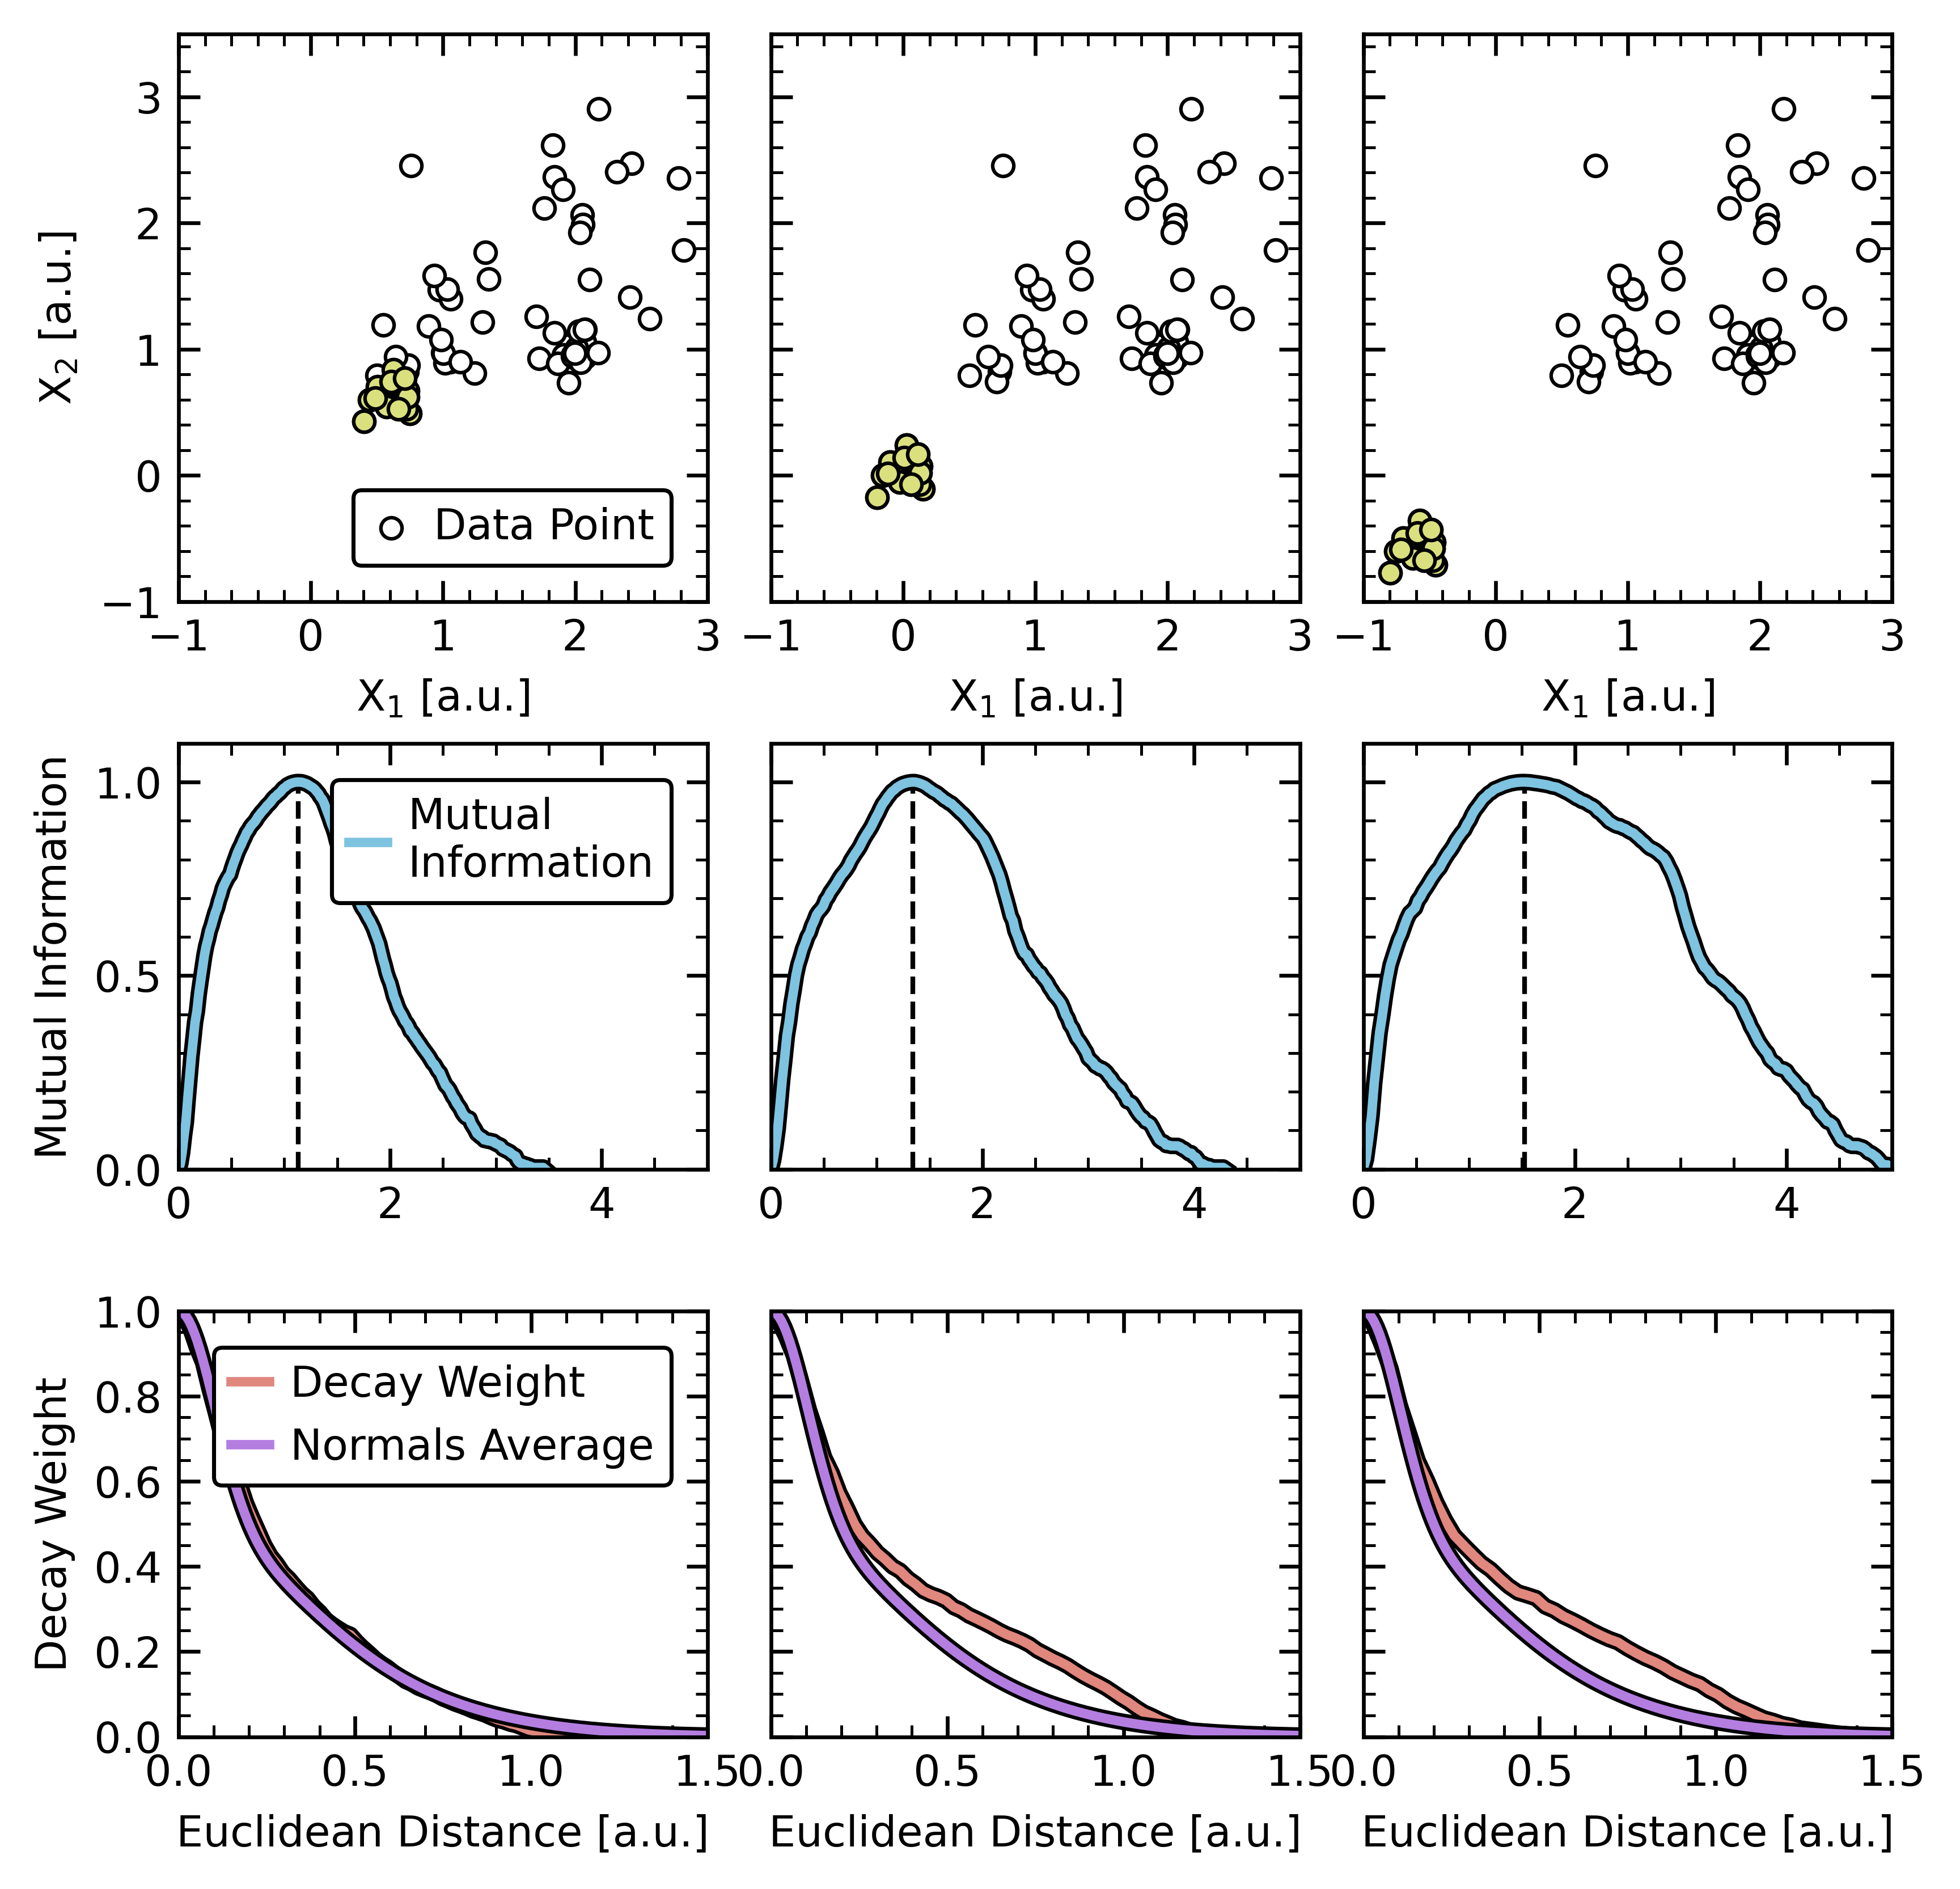

In [3]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(6.5, 6.5), dpi=600, height_ratios=[1, 0.75, 0.75])

# set hspace and wspace
fig.subplots_adjust(hspace=0.3, wspace=0.12)

for i, pos in enumerate([0.6, 0.0, -0.6]):
    blob_params = set_blob_params(pos)
    X = get_X(blob_params)
    X_dm = squareform(pdist(X, metric="euclidean"))

    # Create the scatter plot
    ax[0, i].scatter(X[:, 0], X[:, 1], s=20,lw=0.75, fc='w', ec='k')
    ax[0, i].scatter(X[:20, 0], X[:20, 1], s=20, lw=0.75, fc='#DAE07E', ec='k')
    ax[0,i].set_ylim(-1.0, 3.5)
    ax[0,i].set_xlim(-1.0, 3)
    ax[0,i].set_xticks([-1, 0, 1, 2, 3])
    ax[0,i].set_xlabel("X$_1$ [a.u.]")

    num_thresh = 200
    cutoff, mi_profile = get_MI_profile(X_dm, num_thresh)
    minov_dens, weight_function = compute_MI_density(X_dm, cutoff, mi_profile)
    minov_dens = minov_dens / minov_dens.max()  # normalize to [0, 1] for colorbar

    # set to zero after cutoff
    mask = np.linspace(0, np.max(X_dm), num_thresh) <= cutoff

    x = np.linspace(0, np.max(X_dm), num_thresh)[mask]
    y = 1-mi_profile[mask]/mi_profile[mask].max()

    ax[1, i].vlines(cutoff, 0, 1, lw=1, color="k", ls="--")
    ax[1, i].plot(np.linspace(0, np.max(X_dm), num_thresh), mi_profile, lw=3.5, color="k")
    ax[1, i].plot(np.linspace(0, np.max(X_dm), num_thresh), mi_profile/np.max(mi_profile), color="#7EC3E0", lw=2)
    ax[1,i].set_ylim(0.0, 1.1)
    ax[1, i].set_yticks([0.0, 0.5, 1.0])
    ax[1,i].set_xlim(0.0, 5)
    ax[1, i].set_xticks([0, 2, 4])

    ax[2,i].plot(np.linspace(0, np.max(X_dm), num_thresh)[mask], (1-(mi_profile/np.max(mi_profile))[mask]), lw=3.5, color="k", zorder=1)
    ax[2,i].plot(np.linspace(0, np.max(X_dm), num_thresh)[mask], (1-(mi_profile/np.max(mi_profile))[mask]), lw=2, color="#E0877E", zorder=2)
    ax[2,i].plot(x_pdf, pdf_sum, lw=3.5, color="k")
    ax[2,i].plot(x_pdf, pdf_sum, lw=2, color="#B47EE0")
    ax[2,i].set_ylim(0.0, 1.0)
    ax[2,i].set_xlim(0.0, 1.5)
    ax[2,i].set_xlabel("Euclidean Distance [a.u.]")

    if i == 0:
        ax[0, i].set_ylabel("X$_2$ [a.u.]")
        ax[1, i].set_ylabel("Mutual Information")
        ax[2, i].set_ylabel("Decay Weight")

    if i > 0:
        ax[0,i].set_yticklabels([])
        ax[1,i].set_yticklabels([])
        ax[2,i].set_yticklabels([])


ax[0,0].scatter([],[], s=20, lw=0.75, fc='w', ec='k', label='Data Point')
legend = ax[0,0].legend(frameon=True, framealpha=1, edgecolor="k", loc='lower right')
legend.get_frame().set_linewidth(0.85)

ax[1,0].plot([],[], color='#7EC3E0', label='Mutual\nInformation')
legend = ax[1,0].legend(frameon=True, framealpha=1, edgecolor="k", loc='upper right', handlelength=0.9)
legend.get_frame().set_linewidth(0.85)

ax[2,0].plot([],[], color='#E0877E', label='Decay Weight')
ax[2,0].plot([],[], color='#B47EE0', label='Normals Average')
legend = ax[2,0].legend(frameon=True, framealpha=1, edgecolor="k", loc='upper right', handlelength=0.9)
legend.get_frame().set_linewidth(0.85)

plt.show()